In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt, norm 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
import pandas as pd
import matplotlib.pylab as pylab
params = {'legend.fontsize': 25,
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':'x-large',
          'axes.titlesize' : 'x-large'}
pylab.rcParams.update(params)
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import port_measures as pm

In [2]:
# import requests
# import yfinance as yf
# import pickle
# ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
# groups_according_to_ticker = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
# start_date= "2016-01-01"
# end_date="2023-02-01"

# data = yf.download(ticker_list, start_date , end_date)
# log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = data['Adj Close'].iloc[1:]
# groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

# gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,
#         'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

            
# with open(f'../data/case_study_etf/raw_etf.pkl', 'wb') as handle:
#         pickle.dump(gogn, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [3]:
# response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" )
# ticker_data = pd.read_html(response.content)[0]
# ticker_data['group'] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2


# rndstate = np.random.RandomState(1)
# index = rndstate.choice(np.array(range(500)),size = 30,replace=False)
# ticker_list = np.array(ticker_data['Symbol'].iloc[index]).tolist()
# groups_according_to_ticker = np.array(ticker_data['group'].iloc[index])

# start_date= "2016-01-01"
# end_date="2023-02-01"

# data = yf.download(ticker_list, start_date , end_date)
# assert np.sum(np.sum(data.isna())) == 0

# log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = data['Adj Close'].iloc[1:]
# groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

# gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,
#         'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

            
# with open(f'../data/case_study_etf/raw_30_assets.pkl', 'wb') as handle:
#         pickle.dump(gogn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
import pickle
kappa_const = 1
lik_type = 't'
obs_per_graph = 20
asset_type = 'ind'
# parameters
l = 20
#base_kappa = 0.9
nr_quad = 10

# data
# 0 ind, energy, mat, 
# 1 consumer, communication
# 2 fin. real, health, tech
if asset_type == 'ind':
    with open(f'../data/case_study_etf/raw_30_assets.pkl', 'rb') as handle:
        data = pickle.load(handle)

    ticker_list = data['ticker_list']
    #log_returns = data['log_returns']
    log_returns_scaled = data['log_returns_scaled']
    price = data['price']
    groups = data['groups']

    name = f'{lik_type}_nr_quad_{nr_quad}_ind_30'
else:
    with open(f'../data/case_study_etf/raw_etf.pkl', 'rb') as handle:
        data = pickle.load(handle)

    ticker_list = data['ticker_list']
    #log_returns = data['log_returns']
    log_returns_scaled = data['log_returns_scaled']
    price = data['price']
    groups = data['groups']
    name = f'{lik_type}_nr_quad_{nr_quad}_{asset_type}'

if np.isin(lik_type, ['group-t', 'skew-group-t']):
    max_iter = 80
else:
    max_iter = 100


name = f'{name}_k_{kappa_const}_disjoint_{obs_per_graph}'

# 0 util, energy, materials, industrials
# 1 communication, conusmer, consumer
# health, real, fin. TECH


alphas = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
time_index = range(500, 1600, l)
tol = 1e-6



pbar = tqdm.tqdm(total = len(time_index)*len(alphas), position=1)


i = 500
alpha = 0.1


lwr = np.max((i-500,0))
# nr_graphs = int(np.ceil((i-lwr-obs_per_graph)/l +1))
nr_graphs = int(np.ceil(i-lwr/obs_per_graph))




#kappa = 1*np.array([base_kappa**(pwr) for pwr in range(nr_graphs)])
kappa = kappa_const*np.ones(nr_graphs)
kappa_gamma = kappa



pbar.set_description(f"i {i}, alpha {alpha}")
mu = np.mean(log_returns_scaled.iloc[lwr:i],axis = 0)
dg_opt = dg.dygl(obs_per_graph = obs_per_graph, max_iter = max_iter, lamda = obs_per_graph*0.6, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*kappa_gamma, 
                tol = tol, X_type = 'disjoint', l = l)
dg_opt.fit(np.array(log_returns_scaled[lwr:i]-mu), nr_workers=1, temporal_penalty="ridge", lik_type=lik_type, nu = None,verbose=True, 
            theta_init= None, groups = groups,nr_quad = nr_quad)

ModuleNotFoundError: No module named 'picke'

In [49]:
np.round(dg_opt.theta[-1],2)

array([[ 0.66, -0.  ,  0.  ,  0.  , -0.03,  0.  , -0.  , -0.  ,  0.02,
        -0.01, -0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.08,  0.  , -0.  ,  0.  , -0.  , -0.01, -0.  , -0.  ,  0.  ,
        -0.06, -0.  , -0.  ],
       [-0.  ,  0.95,  0.  , -0.06,  0.  , -0.  ,  0.  , -0.  ,  0.  ,
         0.  , -0.05,  0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ,
        -0.  ,  0.  , -0.  , -0.  , -0.03, -0.32, -0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.23, -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  , -0.1 ,  0.  ,  0.  ,  0.  ,  0.  , -0.02,  0.  ,
         0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,
         0.  , -0.14,  0.  ],
       [ 0.  , -0.06, -0.  ,  0.49,  0.03, -0.  ,  0.  , -0.  , -0.  ,
         0.02,  0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.09, -0.09,
         0.  ,  0.  , -0.11, -0.1 ,  0.  ,  0.  ,  0.  , -0.13, -0.  ,
        -0.1 ,  0.  ,  0.  ],
       [-0.03,  0.  ,  0.  ,

In [36]:
dg_opt.theta[0]

array([[ 1.55536996e+00, -1.11576515e-01, -1.50784235e-03,
         6.14509881e-02, -2.63023882e-02, -6.18282109e-02,
         4.01790699e-02, -8.72915856e-02,  1.14061617e-02,
         1.03727049e-02,  8.41962378e-02, -1.57929537e-01,
        -4.13945750e-03,  9.31325555e-03, -1.00098285e-01,
        -2.20313965e-01,  3.48967701e-02,  4.75560557e-02,
        -8.20834367e-02, -1.45667767e-01, -1.36065643e-02,
         3.39123867e-02, -1.84944916e-01, -1.25366677e-02,
        -9.11661478e-02, -2.84892806e-02, -1.19553164e-01,
        -8.04549709e-02, -1.10994577e-01,  8.16377152e-02],
       [-1.11576515e-01,  2.37221138e+00,  1.10659272e-01,
        -1.06949123e-02,  1.68741639e-01,  7.68652067e-02,
         2.74898168e-02, -7.71018829e-02,  1.84810014e-02,
        -1.96627728e-02,  1.10851095e-02,  1.94592270e-02,
        -5.07007112e-02, -2.81759132e-01, -1.20306605e-01,
         1.41131011e-01, -1.02166714e-01,  1.02524605e-01,
         1.02460963e-01,  2.64099855e-02,  1.17011270e-

In [2]:
prec_1 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.55151515],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.55151515,  0.        , -0.60606061,  1.51515152]])

prec_2 = np.array([[ 1.51515152,  0.        , -1.06060606,  0.0],
                    [ 0.        ,  2.5       ,  0.        ,  0.        ],
                    [-1.06060606,  0.        ,  4.24242424, -0.60606061],
                    [ 0.0,  0.        , -0.60606061,  1.51515152]])

In [3]:
[4] * 4

[4, 4, 4, 4]

In [4]:
n = 100
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
print(dg.generalized_skew_t( X[0], np.linalg.inv(prec_1), nu = [4] * 4, gamma = None, n = 5))
mvt.pdf(X[0], loc = np.zeros(4), shape= np.linalg.inv(prec_1), df = 4)

0.004336911564009564


0.015295672113598745

In [5]:
from multiprocessing.pool import Pool
n = 100
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
obs_per_graph = 100  
dg_opt1 = dg.sgl( max_iter = 200, lamda = obs_per_graph*0.1,  tol = 1e-6)
dg_opt1.fit(X, nr_workers=2, lik_type="group-t", time_index=range(X.shape[0]), nu = None, groups = [0]*4, pool = Pool(10) )


Error 1.18E-6:  59%|█████▉    | 118/200 [01:05<00:12,  6.74it/s]

KeyboardInterrupt: 

In [3]:
n = 100
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
obs_per_graph = 100  
dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 200, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X, nr_workers=2, temporal_penalty="element-wise", lik_type="group-t", time_index=range(X.shape[0]), nu = [4]*4, groups = [0]*4)


  0%|          | 0/200 [00:00<?, ?it/s]

TypeError: object of type 'int' has no len()

In [6]:
dg_opt1.gamma[0]

array([0.00910744, 0.0080557 , 0.00337167, 0.0107424 ])

In [8]:
np.round(dg_opt1.theta[0],3)


array([[ 1.499,  0.   , -0.191, -0.   ],
       [ 0.   ,  2.406,  0.   , -0.   ],
       [-0.191,  0.   ,  4.966,  0.   ],
       [-0.   , -0.   ,  0.   ,  1.718]])

# T vs Normal

In [11]:

n = 1000
X1 = mvt.rvs(shape = np.linalg.inv(prec_0),  df = 4, size = n)
X2 = mvt.rvs(shape = np.linalg.inv(prec_0),  df = 4, size = n)
X = np.vstack((X1,X2))
obs_per_graph = 100  

error_F_t = []
error_F_n = []
error_zo_t = []
error_zo_n = []
error_l1_t = []
error_l1_n = []

alpha = np.linspace(0, 0.1, 10)

for i in range(len(alpha)):
    print(i)

    dg_t = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 2000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.05, tol = 1e-6)
    dg_t.fit(X, nr_workers=7, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 2, time_index=range(X.shape[0]), nu = 4,verbose=False)

    tmp_F = []
    tmp_zo = []
    tmp_l1 = []
    for j in range(20):
        if j <10:
            tmp_zo.append(calc_one_zero_error(prec_0, dg_t.theta[j]))
            tmp_F.append(scipy.linalg.norm(prec_0- dg_t.theta[j],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(prec_0- dg_t.theta[j],ord = 1))
        else:
            tmp_zo.append(calc_one_zero_error(prec_0, dg_t.theta[j]))
            tmp_F.append(scipy.linalg.norm(prec_0- dg_t.theta[j],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(prec_0- dg_t.theta[j],ord = 1))

    error_F_t.append(np.mean(tmp_F))
    error_zo_t.append(np.mean(tmp_zo))
    error_l1_t.append(np.mean(tmp_l1))


    dg_norm = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 2000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.05, tol = 1e-6)
    dg_norm.fit(X, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]),verbose=False)

    tmp_F = []
    tmp_zo = []
    tmp_l1 = []
    for j in range(20):
        if j <10:
            tmp_zo.append(calc_one_zero_error(prec_0, dg_norm.theta[j]))
            tmp_F.append(scipy.linalg.norm(prec_0- dg_norm.theta[j],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(prec_0- dg_norm.theta[j],ord = 1))
        else:
            tmp_zo.append(calc_one_zero_error(prec_0, dg_norm.theta[j]))
            tmp_F.append(scipy.linalg.norm(prec_0- dg_norm.theta[j],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(prec_0- dg_norm.theta[j],ord = 1))

    error_F_n.append(np.mean(tmp_F))
    error_zo_n.append(np.mean(tmp_zo))
    error_l1_n.append(np.mean(tmp_l1))


    







0
1
2
3
4
5
6
7
8
9


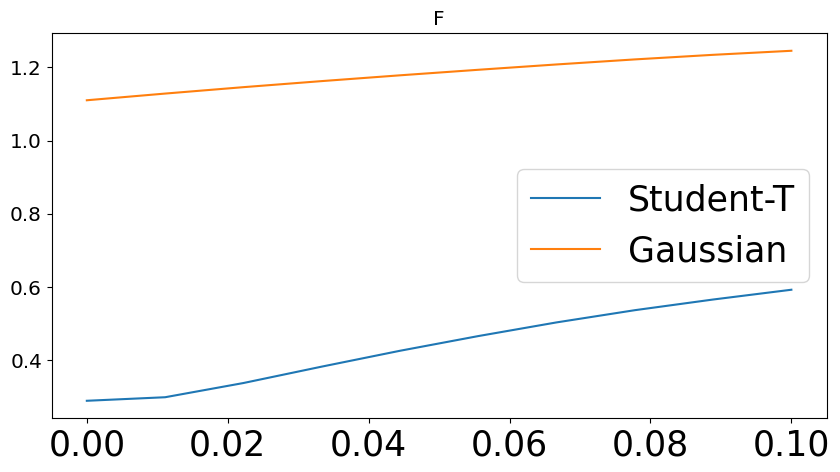

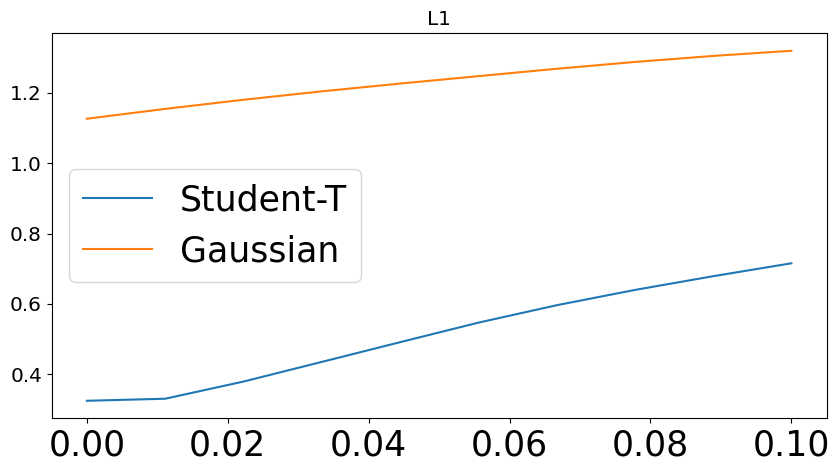

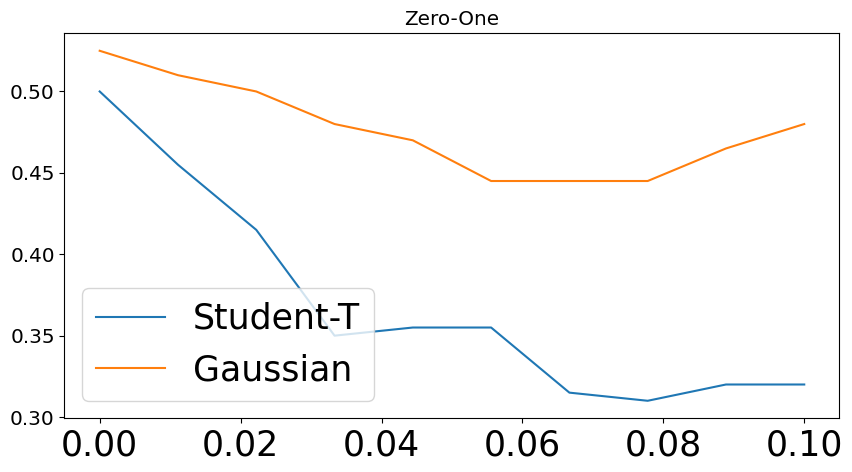

In [12]:

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,error_F_t, label = "Student-T")
ax.plot(alpha,error_F_n, label = "Gaussian")
ax.set_title("F")
ax.legend()


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,error_l1_t, label = "Student-T")
ax.plot(alpha,error_l1_n, label = "Gaussian")
ax.set_title("L1")
ax.legend()

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,error_zo_t, label = "Student-T")
ax.plot(alpha,error_zo_n, label = "Gaussian")
ax.set_title("Zero-One")
ax.legend()


# Group T test

In [ ]:
from scipy.stats import chi2, multivariate_normal, multivariate_t
def generate_group_t(n, cov, nu):

    d = len(nu)
    x = np.zeros(shape = (n,d))
    T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(d)])

    for j in range(n):
        z = T(np.random.uniform())

        x[j] = np.sqrt(np.reciprocal(z))*multivariate_normal.rvs(mean = np.zeros(d), cov = cov)

    return x
        

n = 1000
nu = [4,4,10,10]
groups = [0,0,1,1]
X1 = generate_group_t(n, np.linalg.inv(prec_1), nu = nu)
X2 = generate_group_t(n, np.linalg.inv(prec_2), nu = nu)
X = np.vstack((X1,X2))
X.shape    
obs_per_graph = 50
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.9, tol = 1e-6)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="ridge", lik_type="group-t", nr_em_itr = 2, time_index=range(X.shape[0]), nu = nu,groups = groups)


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
group-t update
starting E-step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


# Outer EM

Error 2.14E-3: 100%|█████████▉| 299/300 [00:00<00:00, 465.96it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel_outer.py:264: UserWarning: Max EM iterations reached. Tolerance is 2.14E-3
  warnings.warn(f'Max EM iterations reached. Tolerance is {Decimal(self.fro_norm):.2E}')
Error 2.14E-3: 100%|██████████| 300/300 [00:00<00:00, 430.32it/s]


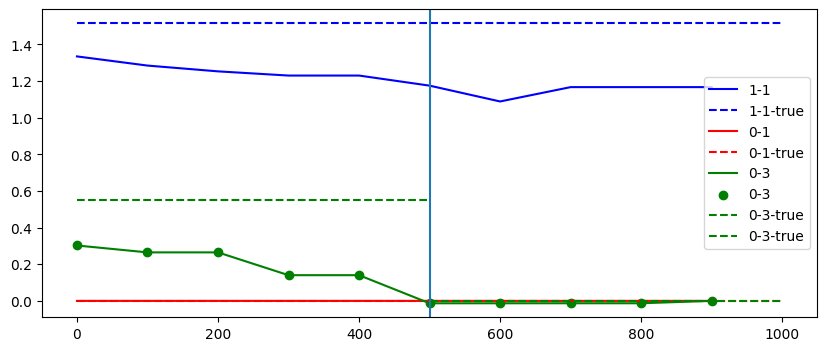

In [105]:
n = 500
X1 = mvt.rvs(shape = np.linalg.inv(prec_1),  df = 4, size = n)
X2 = mvt.rvs(shape = np.linalg.inv(prec_2),  df = 4, size = n)
X = np.vstack((X1,X2))
X.shape      
obs_per_graph = 100


dg_opt1 = dg.dygl_outer_em(obs_per_graph = obs_per_graph, nr_em_its = 300, nr_admm_its = 1, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.05, tol_em = 1e-6)
dg_opt1.fit(X,temporal_penalty="element-wise", nr_em_its = 100, nu = 4, time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.scatter(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.axvline(x  = n)

ax.legend()

# Parallel test

## group t

In [4]:
from scipy.stats import chi2, multivariate_normal, multivariate_t
def generate_group_t(n, cov, nu):

    d = len(nu)
    x = np.zeros(shape = (n,d))
    T = lambda u: np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(d)])

    for j in range(n):
        z = T(np.random.uniform())

        x[j] = np.sqrt(np.reciprocal(z))*multivariate_normal.rvs(mean = np.zeros(d), cov = cov)

    return x
        

n = 1000
nu = [4,4,10,10]
groups = [0,0,1,1]
X1 = generate_group_t(n, np.linalg.inv(prec_1), nu = nu)
X2 = generate_group_t(n, np.linalg.inv(prec_2), nu = nu)
X = np.vstack((X1,X2))
X.shape    
obs_per_graph = 50
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.9, tol = 1e-6)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="ridge", lik_type="group-t", nr_em_itr = 2, time_index=range(X.shape[0]), nu = nu, groups = groups)


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()

  0%|          | 0/10 [00:00<?, ?it/s]

group-t update


C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:137: UserWarning: EM algorithm did not converge. Try to increase number of iterations
  warnings.warn("EM algorithm did not converge. Try to increase number of iterations")


group-t update
group-t update
group-t update


KeyboardInterrupt: 

## Student t

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:307: UserWarning: Observations per graph estimation not divisiable by total number of observations. Last observations not used.
  warnings.warn("Observations per graph estimation not divisiable by total number of observations. Last observations not used.")
Error 1.01E-6:  86%|████████▌ | 857/1000 [00:05<00:00, 159.91it/s]


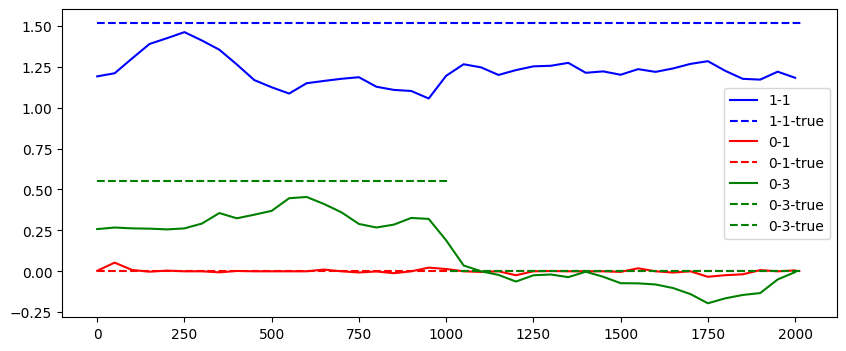

In [4]:

n = 1010
X1 = mvt.rvs(shape = np.linalg.inv(prec_1),  df = 4, size = n)
X2 = mvt.rvs(shape = np.linalg.inv(prec_2),  df = 4, size = n)
X = np.vstack((X1,X2))
X.shape    
obs_per_graph = 50
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.9, tol = 1e-6)
dg_opt1.fit(X, nr_workers=7, temporal_penalty="ridge", lik_type="t", nr_em_itr = 2, time_index=range(X.shape[0]), nu = 4)


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


## Gaussian

In [3]:
from scipy.stats import multivariate_t as mvt
n = 1030
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
obs_per_graph = 100  
dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]))


fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
# ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
print(len(dg_opt1.obs_per_graph_used))
print(dg_opt1.obs_per_graph_used)
ax.legend()


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:161: UserWarning: Observations per graph estimation not divisiable by total number of observations. Last observations not used.
  warnings.warn("Observations per graph estimation not divisiable by total number of observations. Last observations not used.")


NameError: name 'theta_update' is not defined

In [8]:
np.round(dg_opt1.theta[0],2)

array([[ 1.36, -0.  , -0.48,  0.26],
       [-0.  ,  2.44,  0.  , -0.  ],
       [-0.48,  0.  ,  3.6 , -0.  ],
       [ 0.26, -0.  , -0.  ,  1.38]])

In [13]:
np.round(dg_opt1.theta[20],2)

array([[ 1.3 , -0.  , -0.21, -0.  ],
       [-0.  ,  2.76,  0.  ,  0.  ],
       [-0.21,  0.  ,  3.6 , -0.1 ],
       [-0.  ,  0.  , -0.1 ,  1.35]])

# Gaussian likelihood

### Vanilla glasso sklearn

In [ ]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    
from sklearn.covariance import GraphicalLasso
cov = GraphicalLasso(alpha = 0.01).fit(X[:1000])
cov.precision_

array([[ 1.45403064, -0.05780811, -0.98113388,  0.38527548],
       [-0.05780811,  2.45642374, -0.        ,  0.        ],
       [-0.98113388, -0.        ,  4.30993925, -0.46365129],
       [ 0.38527548,  0.        , -0.46365129,  1.38970674]])

## Element-wise

### Estimation with multible observations per block

Error 1.10E-2: 100%|██████████| 100/100 [00:00<00:00, 454.44it/s]


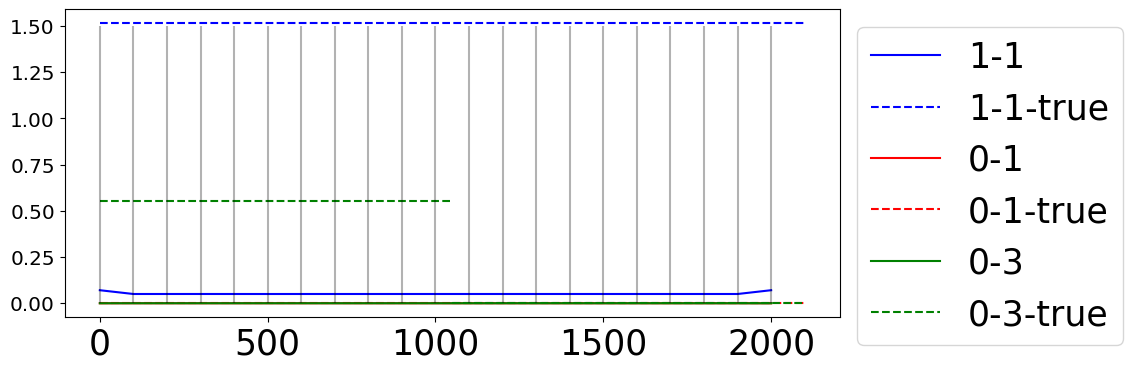

In [9]:
n = 1050
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.0, kappa = obs_per_graph*0, tol = 1e-6)
dg_opt1.fit(X,'element-wise', time_index=range(X.shape[0]))

# dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
# dg_opt2.fit(X,'element-wise', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
#ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], color = 'green', linestyle = '--')

ax.vlines(x = np.array(range(0,2*n,obs_per_graph)), ymin=0, ymax = 1.5, alpha = 0.3, color = 'black')

ax.legend(bbox_to_anchor = [1,1])


In [180]:
dg_opt1.nr_graphs

22

## rank 1 update

Error 1.68E-2: 100%|██████████| 100/100 [00:00<00:00, 1162.52it/s]


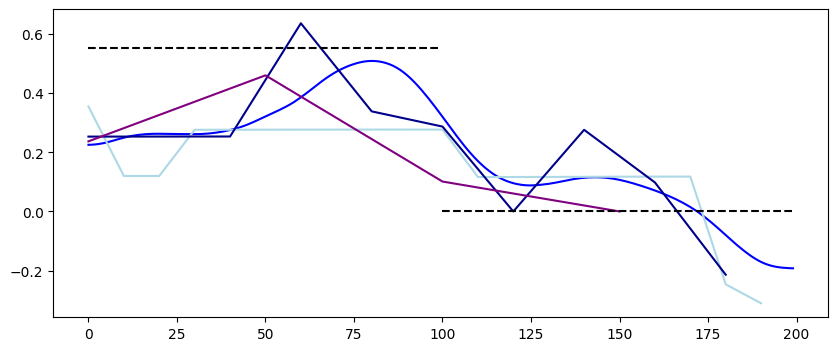

In [36]:
n = 100
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

dg_opt1 = dg.dygl_parallel(obs_per_graph = 1, max_iter = 100, lamda = 0.05, kappa = 5, tol = 1e-6)
dg_opt1.fit(X,'element-wise', time_index= list(range(X.shape[0])))

dg_opt2 = dg.dygl_parallel(obs_per_graph = 10, max_iter = 100, lamda = 10*0.05, kappa = 10*0.1, tol = 1e-6)
dg_opt2.fit(X,'element-wise', time_index= list(range(X.shape[0])))

dg_opt3 = dg.dygl_parallel(obs_per_graph = 20, max_iter = 100, lamda = 20*0.05, kappa = 20*0.01, tol = 1e-6)
dg_opt3.fit(X,'element-wise', time_index= list(range(X.shape[0])))

dg_opt4 = dg.dygl_parallel(obs_per_graph = 50, max_iter = 100, lamda = 50*0.05, kappa = 50*0.01, tol = 1e-6)
dg_opt4.fit(X,'element-wise', time_index= list(range(X.shape[0])))

fig, ax = plt.subplots(1,1, figsize = (10,4))

i = 0
j = 3
ax.plot(dg_opt1.graph_time,dg_opt1.theta[:,i,j], label = f"{i}-{j}", color = 'blue')
ax.plot(dg_opt2.graph_time,dg_opt2.theta[:,i,j], label = f"{i}-{j}", color = 'lightblue')
ax.plot(dg_opt3.graph_time,dg_opt3.theta[:,i,j], label = f"{i}-{j}", color = 'darkblue')
ax.plot(dg_opt4.graph_time,dg_opt4.theta[:,i,j], label = f"{i}-{j}", color = 'purple')
#ax.plot(range(dg_opt2.nr_graphs),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, n-1], [prec_1[i,j], prec_1[i,j]], label = f"{i}-{j}-true", color = 'black', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[i,j], prec_2[i,j]], label = f"{i}-{j}-true", color = 'black', linestyle = '--')

#ax.plot(range(dg_opt1.nr_graphs),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
#ax.plot(range(dg_opt2.nr_graphs),dg_opt2.theta[:,0,1], color = '#ff5971')
#ax.plot([0, dg_opt1.nr_graphs-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

#ax.plot(range(dg_opt1.nr_graphs),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
#ax.plot(range(dg_opt2.nr_graphs),dg_opt2.theta[:,0,3], color = 'lightgreen')
#ax.plot([0, dg_opt1.nr_graphs/2-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
#ax.plot([dg_opt1.nr_graphs/2, dg_opt1.nr_graphs-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

#ax.legend()
#ax.set_xlim([0, dg_opt1.nr_graphs+5])

## Global reconstruction

Error 7.37E-2: 100%|██████████| 100/100 [00:00<00:00, 383.06it/s]


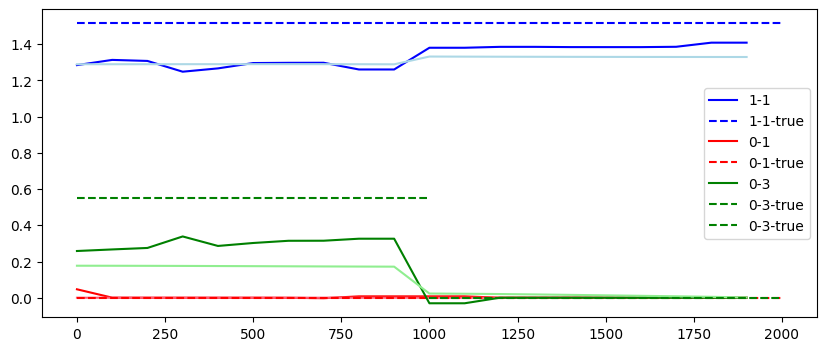

In [37]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'global-reconstruction', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.05, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt2.fit(X,'global-reconstruction', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()


## Ridge

Error 1.24E-1: 100%|██████████| 100/100 [00:00<00:00, 404.77it/s]


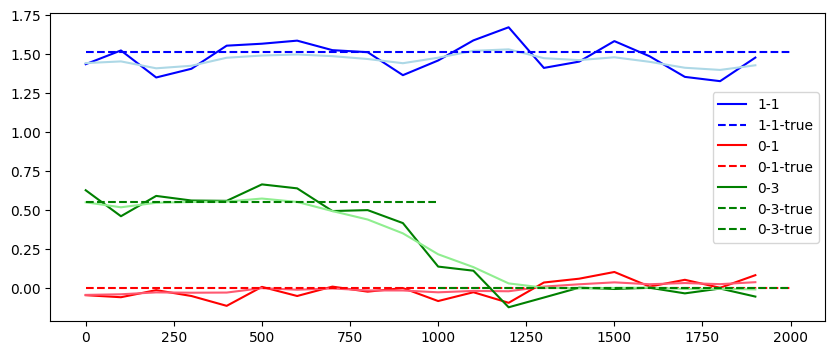

In [38]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = 100, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'ridge', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = 100, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt2.fit(X,'ridge', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()

## Block-Wise reconstruction

Error 1.05E-2:  99%|█████████▉| 99/100 [00:00<00:00, 494.27it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:402: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 1.05E-2: 100%|██████████| 100/100 [00:00<00:00, 469.38it/s]


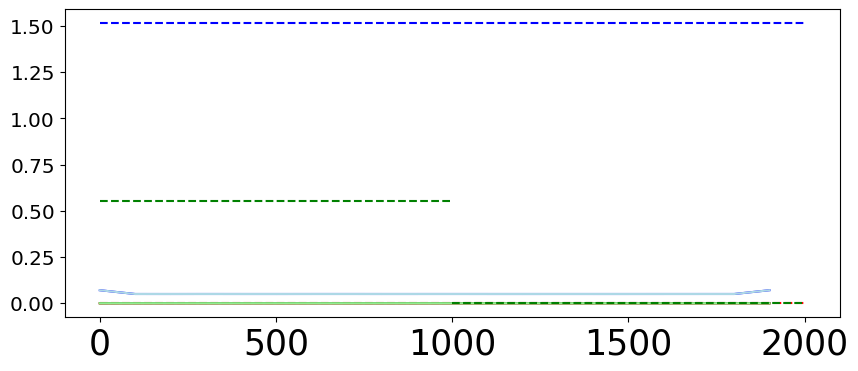

In [6]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0, kappa = obs_per_graph*0, tol = 1e-6)
dg_opt1.fit(X,'block-wise-reconstruction', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.5, tol = 1e-6)
dg_opt2.fit(X,'block-wise-reconstruction', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

## Perturbed Node

Error 1.24E-1: 100%|██████████| 100/100 [00:04<00:00, 23.18it/s]


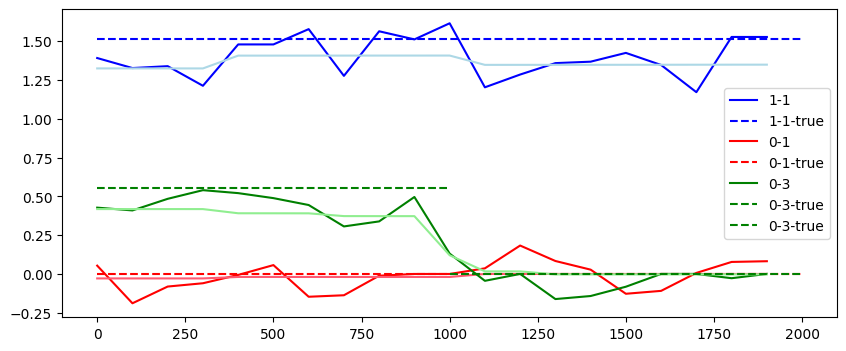

In [7]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape    

obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X,'perturbed-node', time_index=range(X.shape[0]))

dg_opt2 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*0.01, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt2.fit(X,'perturbed-node', time_index=range(X.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (10,4))

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,0], label = "1-1", color = 'blue')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,0], color = 'lightblue')
ax.plot([0, X.shape[0]-1], [prec_1[0,0], prec_1[0,0]], label = "1-1-true", color = 'blue', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,1], label = "0-1", color = 'red')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,1], color = '#ff5971')
ax.plot([0, X.shape[0]-1], [prec_1[0,1], prec_1[0,1]], label = "0-1-true", color = 'red', linestyle = '--')

ax.plot((dg_opt1.graph_time),dg_opt1.theta[:,0,3], label = "0-3", color = 'green')
ax.plot((dg_opt2.graph_time),dg_opt2.theta[:,0,3], color = 'lightgreen')
ax.plot([0, n-1], [prec_1[0,3], prec_1[0,3]], label = "0-3-true", color = 'green', linestyle = '--')
ax.plot([n, 2*n-1], [prec_2[0,3], prec_2[0,3]], label = "0-3-true", color = 'green', linestyle = '--')

ax.legend()

# Large precision

Use emprical log-return precuision

In [1]:

import requests
import pandas as pd
import bs4 


def get_wiki_ticker():
    wiki_page = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
    soup = bs4.BeautifulSoup(wiki_page, 'html.parser')
    table = soup.find("table", {"class":"wikitable sortable"})

    ticker = []
    Sector = []
    SubSector = []
    HqLocation = []
    Founded = []

    # First row is header
    for row in table.findAll('tr')[1:]:
        ticker.append(row.findAll('td')[0].text)
        Sector.append(row.findAll('td')[3].text)
        SubSector.append(row.findAll('td')[4].text)
        HqLocation.append(row.findAll('td')[5].text)
        Founded.append(row.findAll('td')[8].text)

    ticker = list(map(lambda s: s.strip(), ticker))
    Founded = list(map(lambda s: s.strip(), Founded))

    ticker = pd.DataFrame(ticker,columns=['ticker'])
    sector = pd.DataFrame(Sector,columns=['sector'])
    subSector = pd.DataFrame(SubSector,columns=['subSector'])
    hqLocation = pd.DataFrame(HqLocation,columns=['hqLocation'])
    founded = pd.DataFrame(Founded,columns=['founded'])



    return  pd.concat([ticker, sector, subSector, hqLocation,founded],axis=1)

In [2]:
ticker_data = get_wiki_ticker()

In [3]:

def get_yh_price(ticker_list, start_period = '1052125800', interval = '1wk'):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    
    dataframes_price = []

    for i, ticker in enumerate(ticker_list):
        print(f'{i} of {ticker_list.shape[0]-1}')

        # Price data
        url_price = f"http://query2.finance.yahoo.com/v8/finance/chart/{ticker}?symbol={ticker}&period1={start_period}&period2=9999999999&interval={interval}"
        response = requests.get(url_price, headers=headers)
        if response.ok:
            try:
                dates = pd.DataFrame({'timestamp':response.json()["chart"]["result"][0]["timestamp"]})

                #low, open ,volume, close, high
                df_quote = pd.DataFrame(response.json()["chart"]["result"][0]["indicators"]["quote"][0])
                # ad_close
                df_adjclose = pd.DataFrame(response.json()["chart"]["result"][0]["indicators"]["adjclose"][0])

                tmp_df_price = pd.concat([dates, df_quote,df_adjclose], axis=1)
                tmp_df_price['timestamp'] = pd.to_datetime(tmp_df_price['timestamp'], unit = "s")

            except TypeError:
                continue
            except KeyError:
                continue

            tmp_df_price["ticker"] = ticker
            dataframes_price.append(tmp_df_price)

    df_price = pd.concat(dataframes_price)

    return  df_price




In [19]:
df_price = get_yh_price(ticker_data['ticker'], interval = '1d',start_period= 1552311000)
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])
df_price['date'] = df_price['timestamp'].dt.date
df_price['return'] = df_price.groupby(['ticker']).adjclose.pct_change()
price_pivot = df_price[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
import pickle
with open('price_pivot.pkl', 'wb') as handle:
    pickle.dump(price_pivot, handle, protocol=pickle.HIGHEST_PROTOCOL)

0 of 502
1 of 502
2 of 502
3 of 502
4 of 502
5 of 502
6 of 502
7 of 502
8 of 502
9 of 502
10 of 502
11 of 502
12 of 502
13 of 502
14 of 502
15 of 502
16 of 502
17 of 502
18 of 502
19 of 502
20 of 502
21 of 502
22 of 502
23 of 502
24 of 502
25 of 502
26 of 502
27 of 502
28 of 502
29 of 502
30 of 502
31 of 502
32 of 502
33 of 502
34 of 502
35 of 502
36 of 502
37 of 502
38 of 502
39 of 502
40 of 502
41 of 502
42 of 502
43 of 502
44 of 502
45 of 502
46 of 502
47 of 502
48 of 502
49 of 502
50 of 502
51 of 502
52 of 502
53 of 502
54 of 502
55 of 502
56 of 502
57 of 502
58 of 502
59 of 502
60 of 502
61 of 502
62 of 502
63 of 502
64 of 502
65 of 502
66 of 502
67 of 502
68 of 502
69 of 502
70 of 502
71 of 502
72 of 502
73 of 502
74 of 502
75 of 502
76 of 502
77 of 502
78 of 502
79 of 502
80 of 502
81 of 502
82 of 502
83 of 502
84 of 502
85 of 502
86 of 502
87 of 502
88 of 502
89 of 502
90 of 502
91 of 502
92 of 502
93 of 502
94 of 502
95 of 502
96 of 502
97 of 502
98 of 502
99 of 502
100 of 502

In [6]:
import pickle
with open('price_pivot.pkl', 'rb') as handle:
    price_pivot = pickle.load(handle)

In [1]:
from sklearn.datasets import make_sparse_spd_matrix
prec = make_sparse_spd_matrix(
    100, alpha=0.85, smallest_coef=-0.2, largest_coef=0.4, norm_diag = True
)
# tmp = S.copy()
#np.fill_diagonal(tmp,0)
# G = nx.from_numpy_array(tmp)
# print(nx.density(G))
# S = np.linalg.inv(prec)
# A = np.sqrt(np.diag(np.diag(S)**(-1)))
# corr_1 = np.dot(A,S).dot(A)
# prec = np.linalg.inv(corr_1)
# prec[np.abs(prec)<1e-6] = 0
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
# G = nx.fast_gnp_random_graph(300,0.3)
nx.density(G)

NameError: name 'np' is not defined

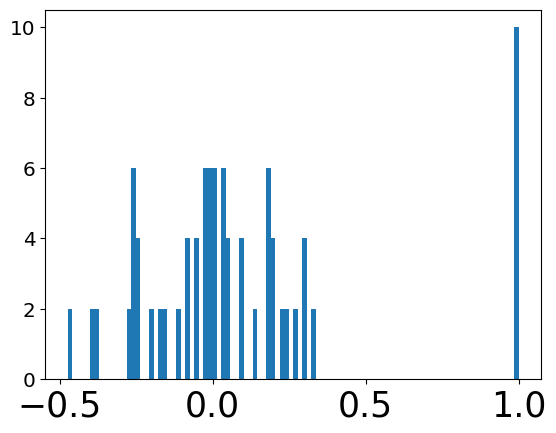

In [265]:
_ = plt.hist(prec.flatten(), bins = 100)

In [50]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
X = X1
obs_per_graph = 100

d = prec.shape[0]
ds = [d]
l1_error = {d:[] for d in ds}
F_error = {d:[] for d in ds}
F_score_error = {d:[] for d in ds}
precision_error = {d:[] for d in ds}
recall_error = {d:[] for d in ds}
density = {d:[] for d in ds}
roc_error = {d:[] for d in ds}
one_zero_error = {d:[] for d in ds}
time_count = {d:[] for d in ds}

alpha = np.linspace(0,1,50)

for i in range(len(alpha)):
    start = time.time()
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 2000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.2, tol = 1e-6)
    dg_opt1.fit(X, nr_workers=10, temporal_penalty="element-wise", lik_type="gaussian",verbose=True)
    elapsed = time.time()-start

    F_error[d].append(np.mean([scipy.linalg.norm(prec- dg_opt1.theta[j],ord = 'fro') for j in range(dg_opt1.theta.shape[0])]))
    F_score_error[d].append(np.mean([calc_f1(prec, dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    precision_error[d].append(np.mean([calc_precision(prec, dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    recall_error[d].append(np.mean([calc_recall(prec, dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    roc_error[d].append(np.mean([calc_roc(prec, dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    density[d].append(np.mean([calc_density(dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    one_zero_error[d].append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    l1_error[d].append(np.mean([scipy.linalg.norm(prec- dg_opt1.theta[j],ord = 1) for j in range(dg_opt1.theta.shape[0])]))
    time_count[d].append(elapsed)



Error 1.01E-6:  34%|███▍      | 675/2000 [00:13<00:26, 49.68it/s]


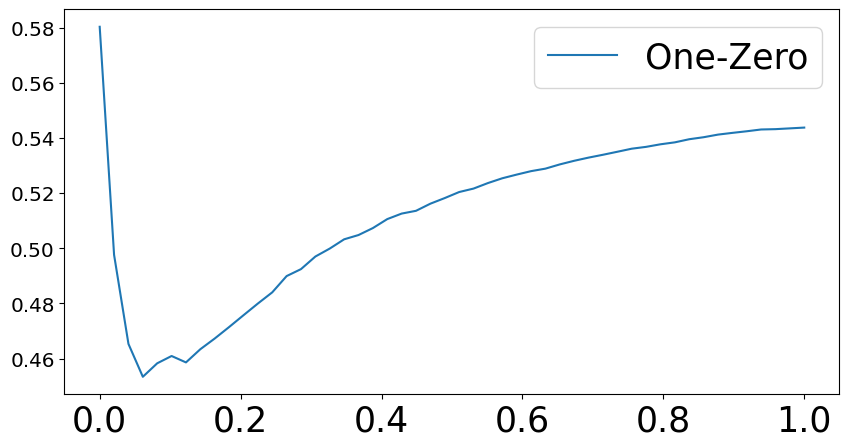

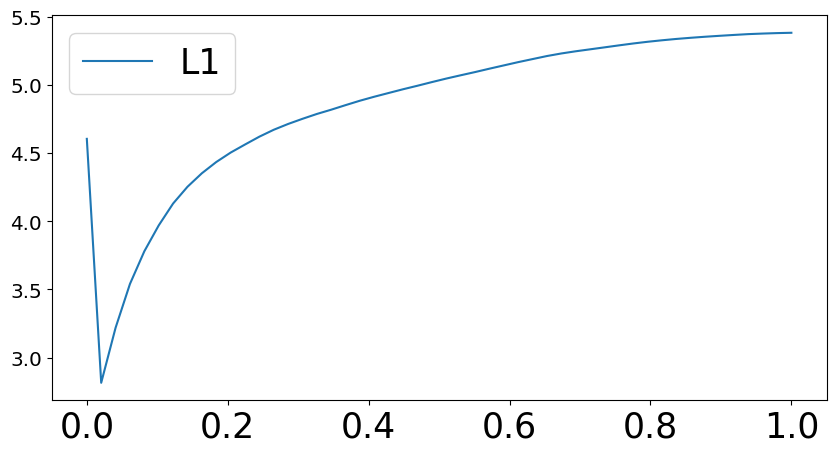

In [53]:

fig, ax = plt.subplots(1,1, figsize = (10,5))
#ax.plot(F_score_error[d], label = 'F_score')
#ax.plot(precision_error[d], label = 'Precision')
#ax.plot(recall_error[d], label = 'Recall')
#ax.plot(roc_error[d], label = 'ROC')
#ax.plot(density[d], label = 'density')
ax.plot(alpha,one_zero_error[d], label = 'One-Zero')
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alpha,l1_error[d], label = 'L1')
ax.legend()

In [260]:


cov = GraphicalLasso(alpha = 0.00 ,max_iter=5000).fit(X)
y_true = np.abs(np.sign(prec[np.triu_indices(d, 1)]))
y_pred = np.abs(np.sign(cov.precision_[np.triu_indices(d, 1)]))
sklearn.metrics.f1_score(y_true,y_pred)

0.4591439688715953

In [33]:

alpha = np.linspace(0,0.15,50)
ds = [5,10,20, 50, 80, 100, 150, 200, 300]
n = 1000


l1_error = {d:[] for d in ds}
F_error = {d:[] for d in ds}
one_zero_error = {d:[] for d in ds}
time_count = {d:[] for d in ds}

pbar = tqdm.tqdm(total = len(alpha)*len(ds))

for d in ds:

    S = np.array(price_pivot.iloc[:,:d].corr())
    u,v = np.linalg.eigh(S)
    u[u<=0] = 0.01
    S = np.dot(v,np.diag(u)).dot(v.T)
    theta = np.linalg.inv(S)
    theta[np.abs(theta)<0.1] = 0  # make precision sparse
    np.sum(theta == 0)/(theta.shape[0]**2)

    for i in range(len(alpha)):

        X1 = np.random.multivariate_normal(mean = np.zeros(theta.shape[0]),cov = np.linalg.inv(theta), size = n)
        X = X1
        obs_per_graph = 100
        start = time.time()
        dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 2000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.05, tol = 1e-6)
        dg_opt1.fit(X, nr_workers=10, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        elapsed = time.time()-start

        for j in range(int(n/obs_per_graph)):
            tmp_F = []
            tmp_zo = []
            tmp_l1 = []

            tmp_zo.append(calc_one_zero_error(theta, dg_opt1.theta[j]))
            tmp_F.append(scipy.linalg.norm(theta- dg_opt1.theta[j],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(theta- dg_opt1.theta[j],ord = 1))


        F_error[d].append(np.mean(tmp_F))
        one_zero_error[d].append(np.mean(tmp_zo))
        l1_error[d].append(np.mean(tmp_l1))
        time_count[d].append(elapsed)

        pbar.set_description(f"{d} {i}")
        pbar.update()

    F_error[d] = np.array(F_error[d])
    one_zero_error[d] = np.array(one_zero_error[d])
    l1_error[d] = np.array(l1_error[d])
    time_count[d] = np.array(time_count[d])

pbar.close()





5 1:   0%|          | 2/450 [00:05<19:07,  2.56s/it]

KeyboardInterrupt: 

In [21]:
# Gaussian_large_scale = {'F':F_error, 'one_zero':one_zero_error, 'l1':l1_error, 'n':n, 'ds':ds, 'alpha':alpha, 'kappa':0.05}
# import pickle
# with open('Gaussian_large_scale.pkl', 'wb') as fp:
#     pickle.dump(Gaussian_large_scale, fp)

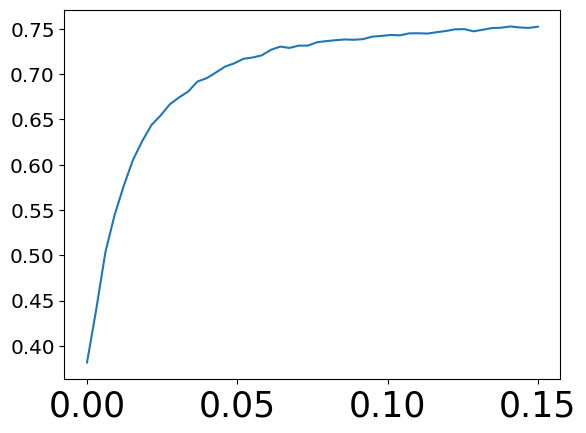

In [30]:
plt.plot(alpha, one_zero_error[300])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

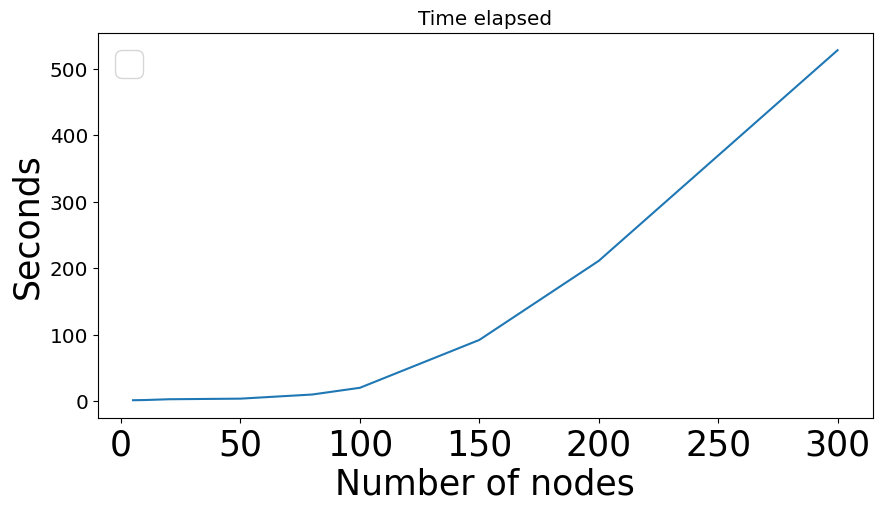

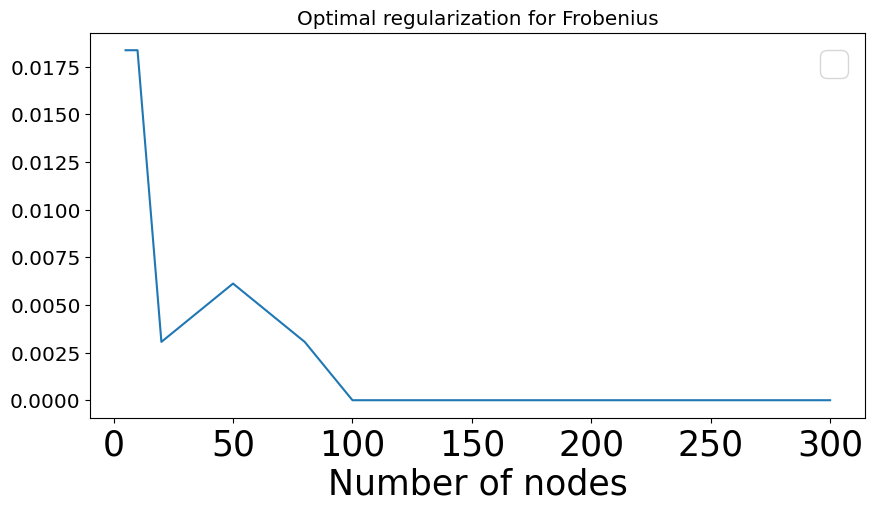

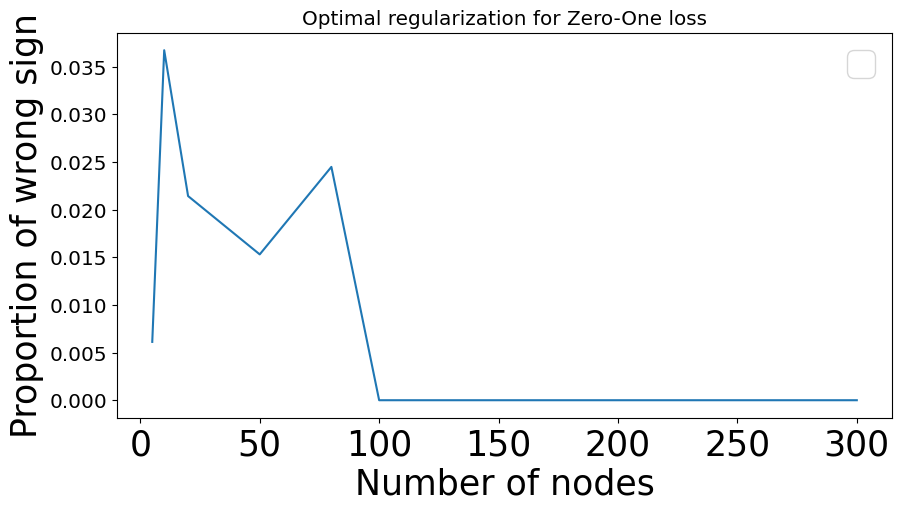

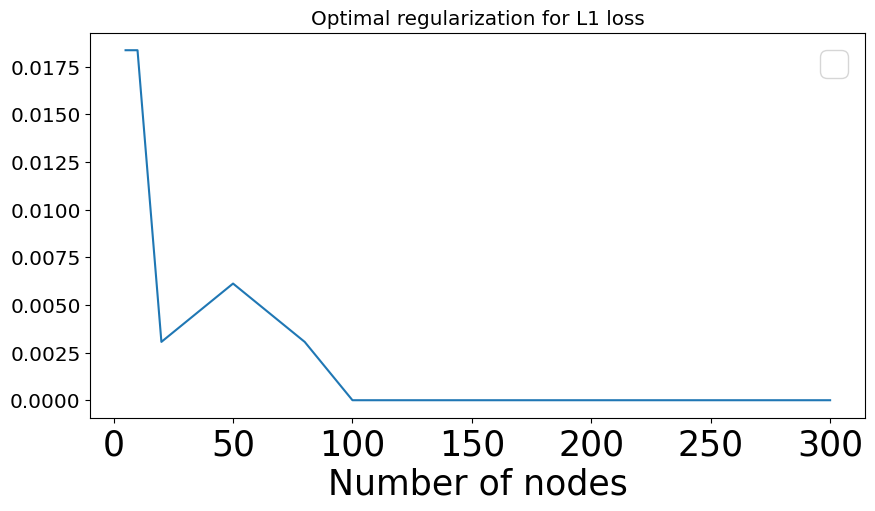

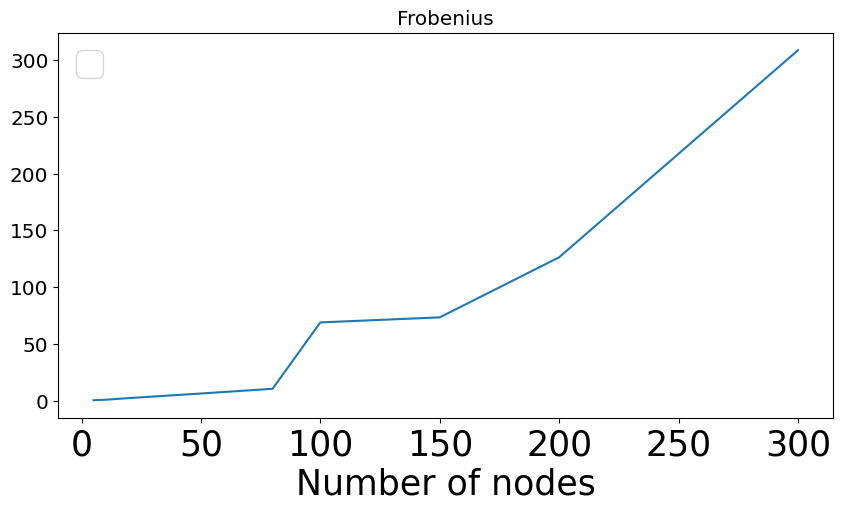

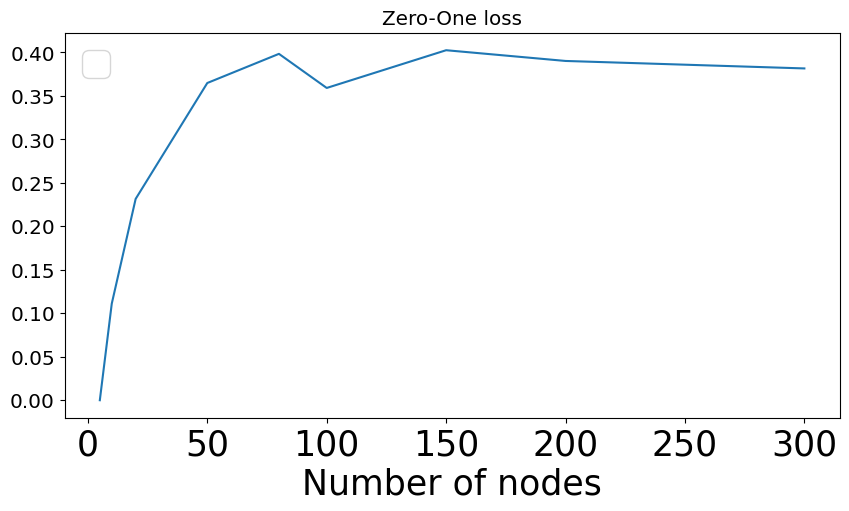

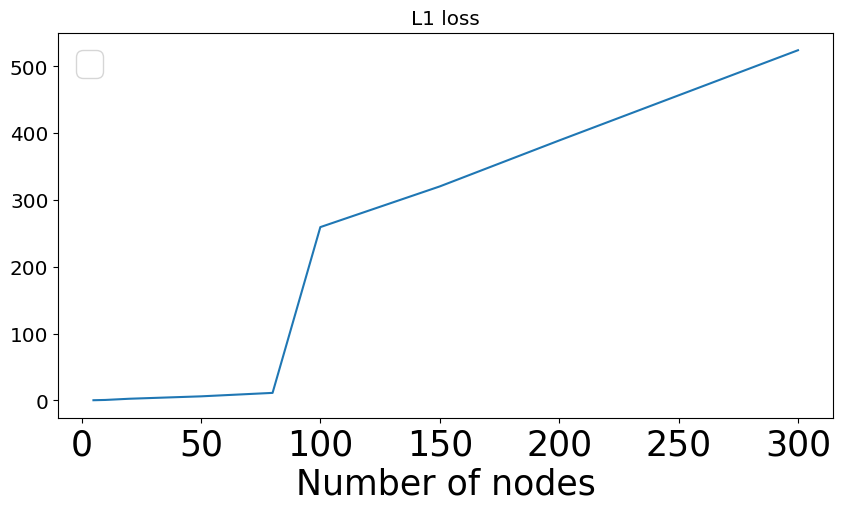

In [16]:

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [np.mean(v) for v in time_count.values()])
ax.set_title("Time elapsed")
ax.set_ylabel("Seconds")
ax.set_xlabel("Number of nodes")
ax.legend()


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [alpha[np.min(F_error[d]) == F_error[d]] for d in ds])
ax.set_title("Optimal regularization for Frobenius")
ax.set_xlabel("Number of nodes")
ax.legend()

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [alpha[np.min(one_zero_error[d]) == one_zero_error[d]][0] for d in ds])
ax.set_title("Optimal regularization for Zero-One loss")
ax.set_ylabel("Proportion of wrong sign")
ax.set_xlabel("Number of nodes")
ax.legend()

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [alpha[np.min(l1_error[d]) == l1_error[d]][0] for d in ds])
ax.set_title("Optimal regularization for L1 loss")
ax.set_xlabel("Number of nodes")
ax.legend()


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [np.array(F_error[d])[np.min(F_error[d]) == F_error[d]][0] for d in ds])
ax.set_title("Frobenius")
ax.set_xlabel("Number of nodes")
ax.legend()

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [np.array(one_zero_error[d])[np.min(one_zero_error[d]) == one_zero_error[d]][0] for d in ds])
ax.set_title("Zero-One loss")
ax.set_xlabel("Number of nodes")
ax.legend()

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(ds,  [np.array(l1_error[d])[np.min(l1_error[d]) == l1_error[d]][0] for d in ds])
ax.set_title("L1 loss")
ax.set_xlabel("Number of nodes")
ax.legend()


# Generate Guassian with this precision matrix and estimate

In [27]:
n = 400
X1 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_1),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(4), cov = np.linalg.inv(prec_2),size=(n) )
X = np.vstack((X1,X2))
X.shape  

prec_list = [prec_1, prec_1, prec_2, prec_2]



# loop
alpha = np.linspace(0,0.2,20)
error = []
l1_error = []
F_error = []
one_zero_error = []

error_glasso = []
l1_error_glasso = []
F_error_glasso = []
one_zero_error_glasso = []
for i in range(len(alpha)):
    print(i)
    obs_per_graph = 100  
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 2000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.1, tol = 1e-10)
    dg_opt1.fit(X, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]), verbose = False)
    one_zero_error.append(np.mean([calc_one_zero_error(prec_list[k], dg_opt1.theta[k]) for k in range(len(prec_list))]))
    l1_error.append(np.mean([scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec_list[k], ord = 1) for k in range(len(prec_list))])) 
    F_error.append(np.mean([scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec_list[k], ord = 'fro') for k in range(len(prec_list))])) 

    # glasso
    gl1 = []
    gf = []
    fzo = []
    for k in range(4):

        cov = GraphicalLasso(alpha=alpha[i],max_iter=2000).fit(X[k*obs_per_graph:obs_per_graph*(k+1)])
        gl1.append(scipy.linalg.norm(prec_list[k]- cov.precision_, ord = 1)/scipy.linalg.norm(prec_list[k], ord = 1))
        gf.append(scipy.linalg.norm(prec_list[k]- cov.precision_, ord = 'fro')/scipy.linalg.norm(prec_list[k], ord = 'fro'))
        fzo.append(calc_one_zero_error(prec_list[k], cov.precision_))


    one_zero_error_glasso.append(np.mean(fzo))
    l1_error_glasso.append(np.mean(gl1))
    F_error_glasso.append(np.mean(gf))




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


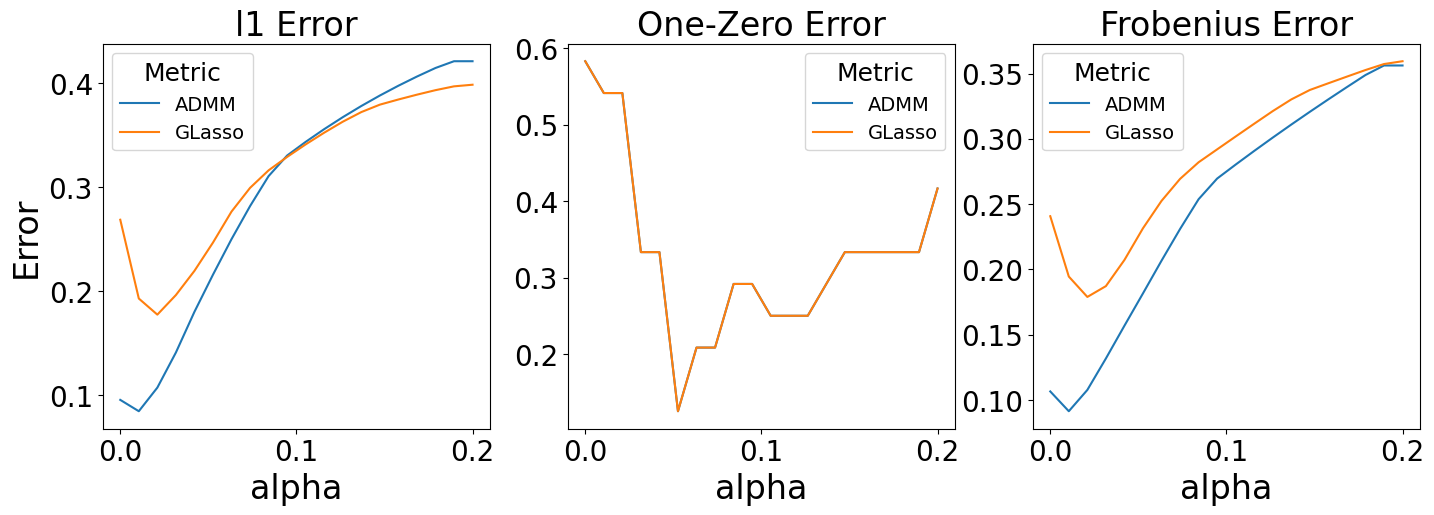

In [31]:
fig, ax = plt.subplots(1,3,figsize = (17,5))
ax[0].plot(alpha,l1_error, label ='ADMM')
ax[0].plot(alpha,l1_error_glasso, label ='GLasso')
legend = ax[0].legend(title = "Metric",fontsize = 14)
legend.get_title().set_fontsize('18')
ax[0].set_title("l1 Error", fontdict = {'fontsize':24})


ax[1].plot(alpha,one_zero_error_glasso, label ='ADMM')
ax[1].plot(alpha,one_zero_error_glasso, label ='GLasso')
legend = ax[1].legend(title = "Metric",fontsize = 14)
legend.get_title().set_fontsize('18')
ax[1].set_title("One-Zero Error", fontdict = {'fontsize':24})

ax[2].plot(alpha,F_error, label ='ADMM')
ax[2].plot(alpha,F_error_glasso, label ='GLasso')
legend = ax[2].legend(title = "Metric",fontsize = 14)
legend.get_title().set_fontsize('18')
ax[2].set_title("Frobenius Error", fontdict = {'fontsize':24})



for i in range(3):
    ax[i].set_xlabel("alpha", fontdict = {'fontsize':24})
    if i == 0:
        ax[i].set_ylabel("Error", fontdict = {'fontsize':24})
    ax[i].tick_params(axis='both', which='major', labelsize=20)


Text(0.5, 1.0, 'F')

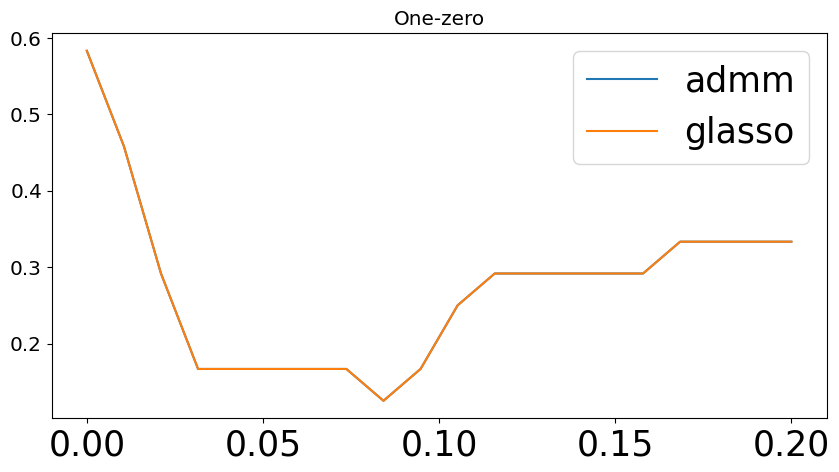

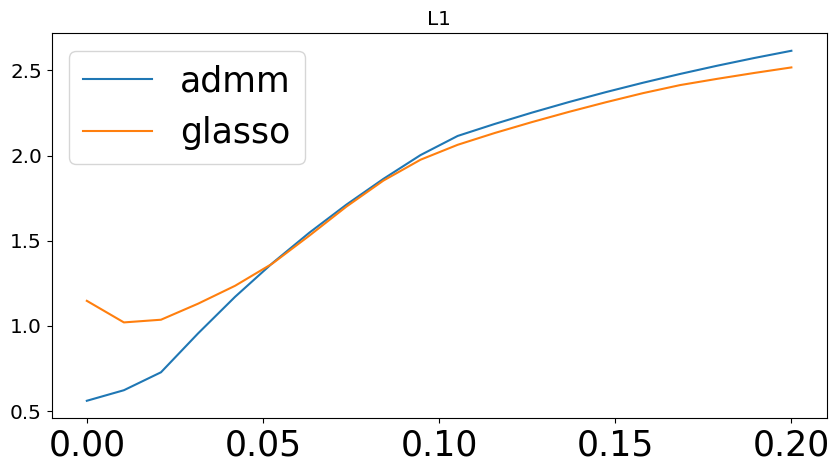

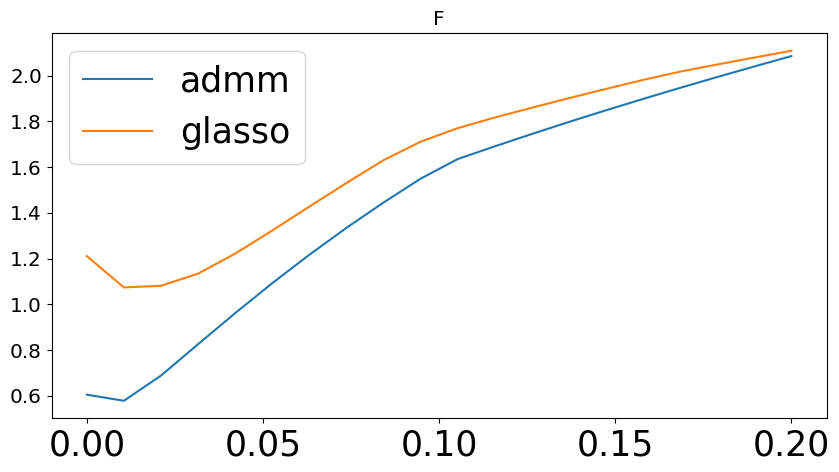

In [14]:

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,one_zero_error_glasso, label = "admm")
ax.plot(alpha,one_zero_error_glasso, label = "glasso")
ax.legend()
ax.set_title("One-zero")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,l1_error, label = "admm")
ax.plot(alpha,l1_error_glasso, label = "glasso")
ax.legend()
ax.set_title("L1")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,F_error, label = "admm")
ax.plot(alpha,F_error_glasso, label = "glasso")
ax.legend()
ax.set_title("F")

# Generate t with this precision matrix and estimate

In [62]:
# Generate t with this precision matrix and estimate
n = 10000
X1 = mvt.rvs(shape = np.linalg.inv(theta),  df = 4, size = n)
X = X1
X.shape
obs_per_graph = 1000
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.01, kappa = obs_per_graph*1, tol = 1e-3)
dg_opt1.fit(X, nr_workers=10, temporal_penalty="ridge", lik_type="t", nr_em_itr = 100, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-3)
np.sum(np.abs(dg_opt1.theta[0] - theta))/np.sum(np.abs(theta))

Error 1.00E-3:  68%|██████▊   | 681/1000 [00:18<00:08, 37.28it/s]


0.5257133897813396

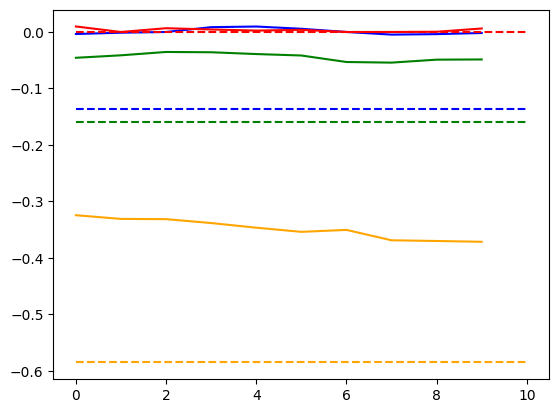

In [64]:
plt.plot(dg_opt1.theta[:,0,1], color = 'blue')
plt.plot([0,10], [theta[0,1], theta[0,1]], linestyle = '--', color = 'blue')

plt.plot(dg_opt1.theta[:,0,3], color = 'red')
plt.plot([0,10], [theta[0,3], theta[0,3]], linestyle = '--', color = 'red')

plt.plot(dg_opt1.theta[:,0,7], color = 'orange')
plt.plot([0,10], [theta[0,7], theta[0,7]], linestyle = '--', color = 'orange')

plt.plot(dg_opt1.theta[:,0,9], color = 'green')
plt.plot([0,10], [theta[0,9], theta[0,9]], linestyle = '--', color = 'green')

# Falling density

In [115]:
from sklearn.datasets import make_sparse_spd_matrix
prec = make_sparse_spd_matrix(50, alpha=0.7, smallest_coef=-0.2, largest_coef=0.4, norm_diag = True)
# tmp = S.copy()
#np.fill_diagonal(tmp,0)
# G = nx.from_numpy_array(tmp)
# print(nx.density(G))
# S = np.linalg.inv(prec)
# A = np.sqrt(np.diag(np.diag(S)**(-1)))
# corr_1 = np.dot(A,S).dot(A)
# prec = np.linalg.inv(corr_1)
# prec[np.abs(prec)<1e-6] = 0
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
# G = nx.fast_gnp_random_graph(300,0.3)
nx.density(G)

0.7371428571428571

In [213]:
prec = make_sparse_spd_matrix(50, alpha=0.7, smallest_coef=-0.9, largest_coef=-0.6, norm_diag = True)
np.linalg.cond(np.dot(prec,prec))

1192901836.4911654

In [188]:
prec = make_sparse_spd_matrix(50, alpha=0.7, smallest_coef=-0.9, largest_coef=-0.6, norm_diag = True)

deltas = np.linspace(0.05, 0.4, 10)
theta = np.zeros(shape =(len(deltas), 50, 50))
for i, delta in enumerate(deltas):
    prec[np.abs(prec)<delta] = 0

    A = np.dot(prec, prec)
    
    A[np.abs(A) < 1e-6] = 0
    theta[i] = A



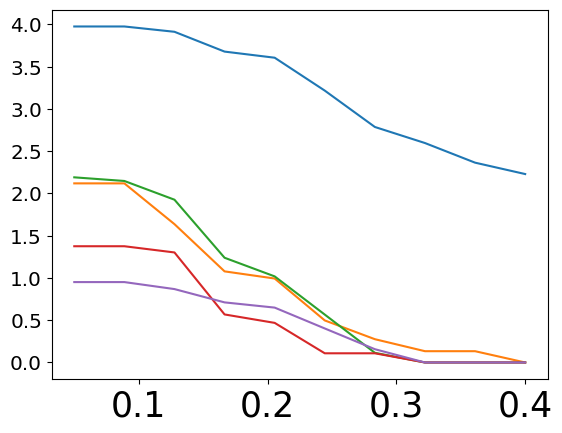

In [189]:
plt.plot(deltas, theta[:,0,0])
plt.plot(deltas, theta[:,0,1])
plt.plot(deltas, theta[:,0,2])
plt.plot(deltas, theta[:,0,3])
plt.plot(deltas, theta[:,0,4])

In [209]:

X = []
for i in range(len(theta)):
    print(np.linalg.cond(theta[i]))
    X.append(np.random.multivariate_normal(mean = np.zeros(50), cov = np.linalg.inv(theta[i]),size=100 ))
    
X = np.vstack(X)

239189449.2902784
52469667.52786681
926114.2333895928
489556.99762760254
551057.8315184321
36508.81927155072
65855.38693891643
705192.4802629699
437846.88961441495
7163.503347363789


C:\Users\User\AppData\Local\Temp\ipykernel_3992\1742070409.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  X.append(np.random.multivariate_normal(mean = np.zeros(50), cov = np.linalg.inv(theta[i]),size=100 ))


In [214]:

l1_error = []
F_error = []
one_zero_error = []


l1_error_glasso = []
F_error_glasso = []
one_zero_error_glasso = []

alpha = np.linspace(0,1,50)

for i in range(len(alpha)):
    start = time.time()
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 2000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.2, tol = 1e-6)
    dg_opt1.fit(X, nr_workers=10, temporal_penalty="ridge", lik_type="gaussian",verbose=True)
    elapsed = time.time()-start

    F_error.append(np.mean([scipy.linalg.norm(theta[j]- dg_opt1.theta[j],ord = 'fro') for j in range(dg_opt1.theta.shape[0])]))
    one_zero_error.append(np.mean([calc_one_zero_error(theta[j], dg_opt1.theta[j]) for j in range(dg_opt1.theta.shape[0])]))
    l1_error.append(np.mean([scipy.linalg.norm(theta[j]- dg_opt1.theta[j],ord = 1) for j in range(dg_opt1.theta.shape[0])]))

    theta_glasso = []
    for k in range(len(theta)):
        cov = GraphicalLasso(alpha = alpha[i] ,max_iter=5000).fit(X[(k*100):(k+1)*100])
        theta_glasso.append(cov.precision_)

    F_error_glasso.append(np.mean([scipy.linalg.norm(theta[j]- theta_glasso[j],ord = 'fro') for j in range(dg_opt1.theta.shape[0])]))
    one_zero_error_glasso.append(np.mean([calc_one_zero_error(theta[j], theta_glasso[j]) for j in range(dg_opt1.theta.shape[0])]))
    l1_error_glasso.append(np.mean([scipy.linalg.norm(theta[j]- theta_glasso[j],ord = 1) for j in range(dg_opt1.theta.shape[0])]))
    


Error 3.22E-4: 100%|█████████▉| 1999/2000 [00:09<00:00, 243.83it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:401: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 6.75E-6: 100%|█████████▉| 1999/2000 [00:09<00:00, 246.59it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:401: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 5.15E-6: 100%|█████████▉| 1999/2000 [00:08<00:00, 246.77it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:401: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 5.46E-6: 100%|█████████▉| 1999/2000 [00:09<00:00, 249.83it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:401: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 6.34E-6: 100%|█████████▉| 1999/2000 [00:08<00:00, 252.21it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:401: UserWarning: Max iterations reached.
  warnings.warn("Max it

Text(0.5, 1.0, 'L1')

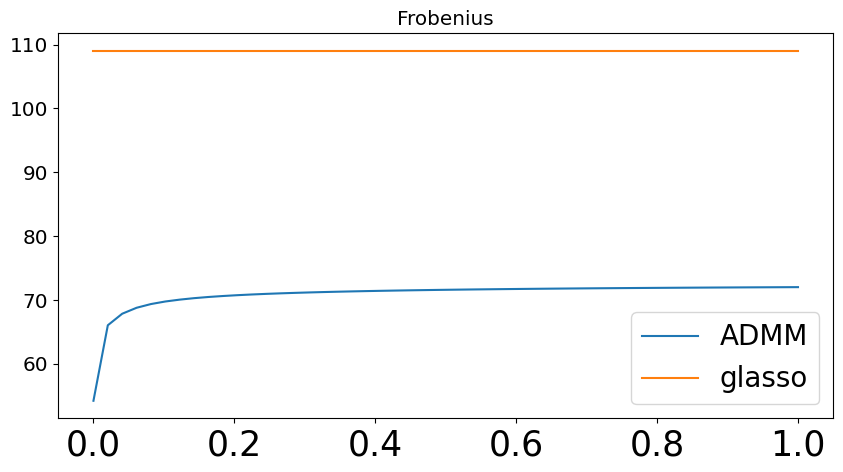

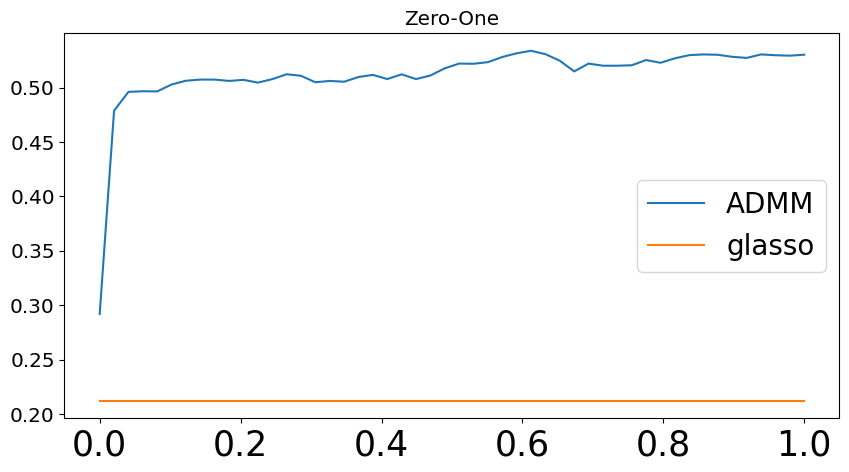

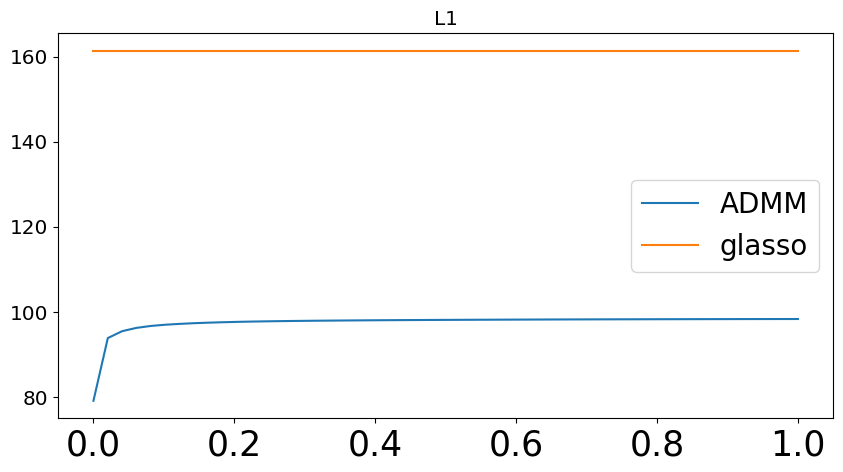

In [215]:
fontsize = 20
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,F_error, label = "ADMM")
ax.plot(alpha,F_error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("Frobenius")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,one_zero_error, label = "ADMM")
ax.plot(alpha,one_zero_error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("Zero-One")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,l1_error, label = "ADMM")
ax.plot(alpha,l1_error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("L1")


# GP

In [43]:
cov_1 = np.linalg.inv(prec_1)
A = np.sqrt(np.diag(np.diag(cov_1)**(-1)))
corr_1 = np.dot(A,cov_1).dot(A)
prec_1_corr = np.linalg.inv(corr_1)
prec_1_corr

array([[ 1.33141609,  0.        , -0.53425134,  0.45333496],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.53425134,  0.        ,  1.22500932, -0.28556936],
       [ 0.45333496,  0.        , -0.28556936,  1.16498908]])

True
[[ 1.          0.          0.36634099 -0.29933259]
 [ 0.          1.          0.          0.        ]
 [ 0.36634099  0.          1.          0.10257107]
 [-0.29933259  0.          0.10257107  1.        ]]
MVN
[[ 1.          0.02708902  0.32324321 -0.40944011]
 [ 0.02708902  1.          0.07014374 -0.05311286]
 [ 0.32324321  0.07014374  1.          0.09320498]
 [-0.40944011 -0.05311286  0.09320498  1.        ]]
U
[[ 1.          0.02731701  0.31550741 -0.38701481]
 [ 0.02731701  1.          0.08320073 -0.07557922]
 [ 0.31550741  0.08320073  1.          0.10453851]
 [-0.38701481 -0.07557922  0.10453851  1.        ]]


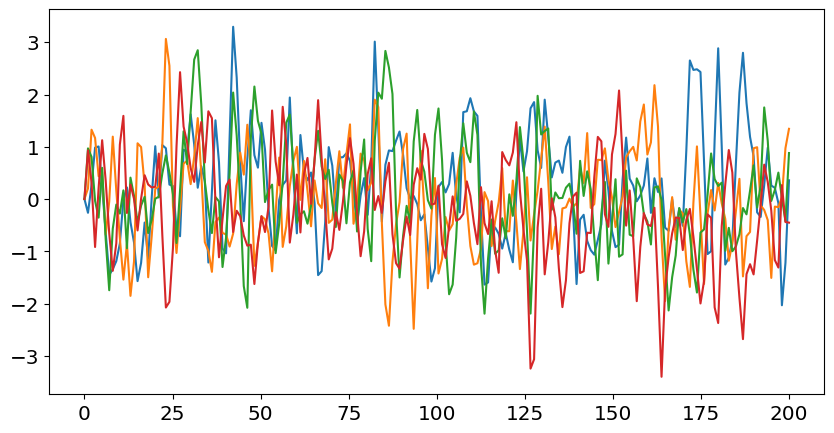

In [71]:
n = 200
t = np.linspace(0,n,n)
d = prec_1_corr.shape[0]
K = np.zeros(shape=(d, n,n))
for j in range(d):
    K[j] = pairwise_kernels(t.reshape(-1,1), metric = 'rbf',gamma = 0.5)


MVN = np.random.multivariate_normal(mean = np.zeros(d),cov = np.linalg.inv(prec_1_corr), size=n)
# generate u
u = norm.cdf(MVN,  scale = 1)

mu_1 = np.zeros(n)
x = np.zeros(shape=(n,d))
for i in range(n):
    for j in range(d):
        if i == 0:
            x[0,j] = 0
        else:
            reg =  1e-4*np.identity(i)
            tmp=K[j][i,i]- np.dot(K[j][i,:i], np.linalg.inv(K[j][:i,:i] + reg)).dot(K[j][i,:i])
            scale = np.sqrt(tmp)
            if tmp <= 0:
                print(f"{i} {j}")
            loc = np.dot(K[j][i,:i], np.linalg.inv(K[j][:i,:i]+reg)).dot(x[:i,j])
            x[i,j] = norm.ppf(u[i,j], loc= loc, scale = scale ) 
            

fig, ax = plt.subplots(1,1,figsize = (10,5))
for j in range(d):
    ax.plot(t,x[:,j])


print("True")
print(corr_1)
print("MVN")
print(np.corrcoef(MVN.T))
print("U")
print(np.corrcoef(u.T))

In [20]:
# Fit GPS..Assume already fitted
# Generate u....
w = 30
u_new = np.zeros(shape = (n,d))
for i in range(n): 

    lwr = np.max((i-w,0))
    upr= np.min((i+w,n))
    idx = np.array(range(lwr,upr,1))
    idx = idx[idx != i]
    for j in range(d):
        reg =  1e-4*np.identity(len(idx))
        loc = 0.0+np.dot(K[j][i,idx], np.linalg.inv(K[j][np.ix_(idx,idx)] + reg)).dot(x[idx,j])
        scale = np.sqrt(K[j][i,i]- np.dot(K[j][i,idx], np.linalg.inv(K[j][np.ix_(idx,idx)] + reg)).dot(K[j][i,idx]))
        u_new[i,j] = norm.cdf(x[i,j], loc= loc, scale = scale ) 

print("corr u")
print(np.corrcoef(u_new.T))

# get x
x_new = norm.ppf(u_new)
print("corr x_new")
print(np.corrcoef(x_new.T))
print("corr true")
print(corr_1)

# Fit dygraph
obs_per_graph = 100  
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(x_new, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(x_new.shape[0]))
print("Estimated")
print(np.round(dg_opt1.theta[0],2))
print("True")
print(prec_1_corr)

cov = GraphicalLasso(alpha=0.15).fit(x_new[:obs_per_graph])
print("glasso")
print(np.round(cov.precision_,2))

NameError: name 'n' is not defined

In [73]:
alpha = np.linspace(0,0.5,40)

error = []
l1_error = []
F_error = []
one_zero_error = []

error_glasso = []
l1_error_glasso = []
F_error_glasso = []
one_zero_error_glasso = []

for i in range(len(alpha)):
    print(i)
    obs_per_graph = 100  
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*alpha[i], kappa = obs_per_graph*0.1, tol = 1e-6)
    dg_opt1.fit(x_new, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(x_new.shape[0]), verbose = False)
    error.append(np.sum((prec_1_corr-dg_opt1.theta[0])**2))
    one_zero_error.append(calc_one_zero_error(prec_1_corr, dg_opt1.theta[0]))
    l1_error.append(scipy.linalg.norm(prec_1_corr- dg_opt1.theta[0],ord = 1))
    F_error.append(scipy.linalg.norm(prec_1_corr- dg_opt1.theta[0],ord = 'fro'))


    # glasso
    cov = GraphicalLasso(alpha=alpha[i],max_iter=2000).fit(x_new[:obs_per_graph])
    error_glasso.append(np.sum((prec_1_corr-cov.precision_)**2))
    one_zero_error_glasso.append(calc_one_zero_error(prec_1_corr, cov.precision_))
    l1_error_glasso.append(scipy.linalg.norm(prec_1_corr- cov.precision_,ord = 1))
    F_error_glasso.append(scipy.linalg.norm(prec_1_corr- cov.precision_,ord = 'fro'))




    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Text(0.5, 1.0, 'F')

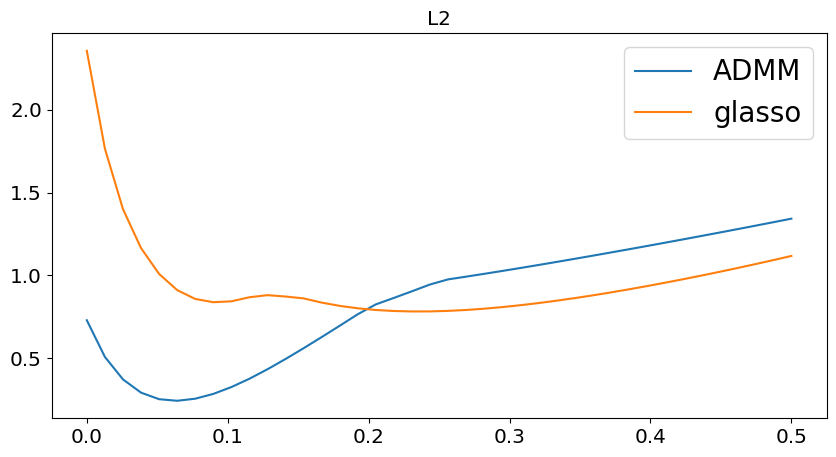

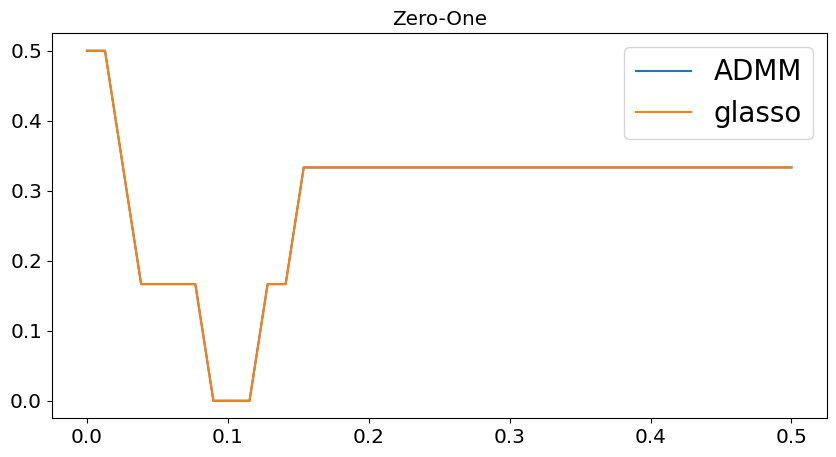

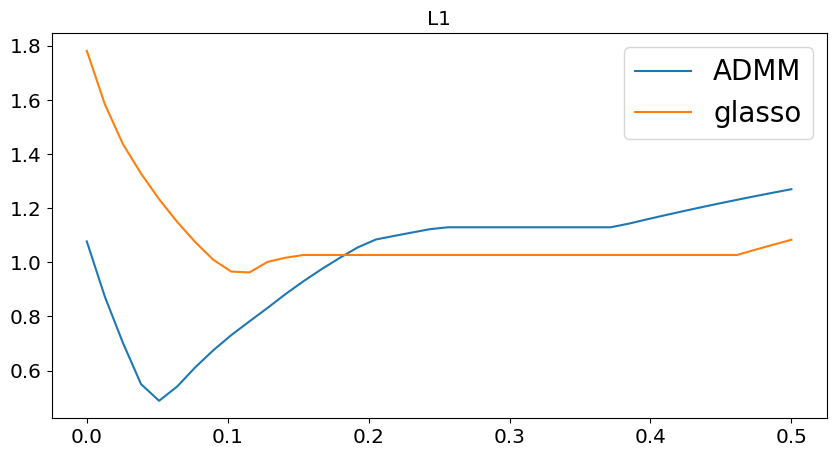

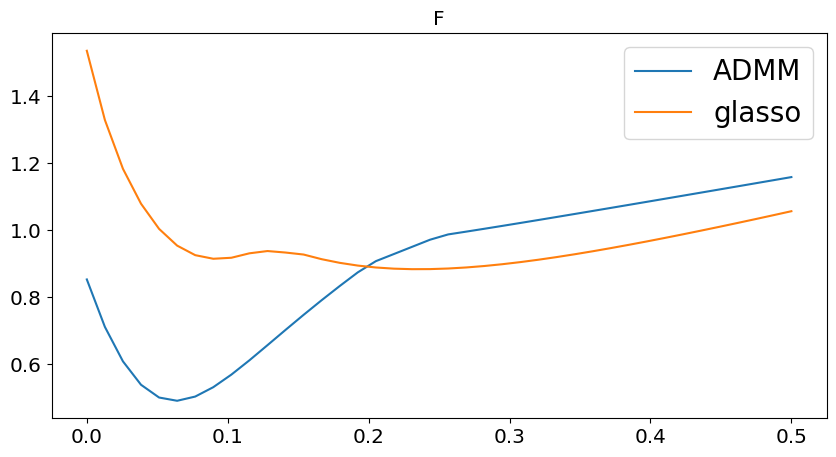

In [74]:

fontsize = 20
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,error, label = "ADMM")
ax.plot(alpha,error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("L2")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,one_zero_error_glasso, label = "ADMM")
ax.plot(alpha,one_zero_error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("Zero-One")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,l1_error, label = "ADMM")
ax.plot(alpha,l1_error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("L1")

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(alpha,F_error, label = "ADMM")
ax.plot(alpha,F_error_glasso, label = "glasso")
ax.legend(fontsize=fontsize)
ax.set_title("F")